# Notebook to investigate creating own MRI preprocessing akin to White Stripe Norm [Shinohara]

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import SimpleITK as sitk
import glob
import pandas as pd
import sys
import torchio as tio
from scipy import stats
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
from src.skmtea_utils import *

## Load test OAI image

In [2]:
raw_data_path = '../nnUNet_data/nnUNet_raw/Dataset361_Menisci/imagesTr/'

files = glob.glob(raw_data_path + '*')

In [3]:
files.sort()
print('Number of files:', len(files))
files[:5]

Number of files: 148


['../nnUNet_data/nnUNet_raw/Dataset361_Menisci/imagesTr/IWOAI_001_0000.nii.gz',
 '../nnUNet_data/nnUNet_raw/Dataset361_Menisci/imagesTr/IWOAI_002_0000.nii.gz',
 '../nnUNet_data/nnUNet_raw/Dataset361_Menisci/imagesTr/IWOAI_003_0000.nii.gz',
 '../nnUNet_data/nnUNet_raw/Dataset361_Menisci/imagesTr/IWOAI_004_0000.nii.gz',
 '../nnUNet_data/nnUNet_raw/Dataset361_Menisci/imagesTr/IWOAI_005_0000.nii.gz']

### Plot the intensity histogram of this image

In [4]:
def plot_histogram(axis, values, num_positions=100, label=None, alpha=0.05, color=None, lw=1):
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=lw, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

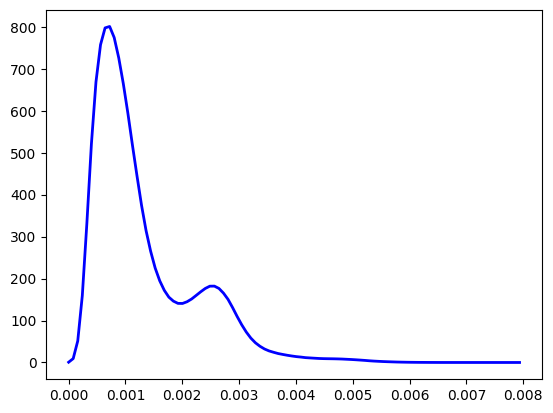

In [5]:
# read in first file (.nii.gz)
image = sitk.ReadImage(files[0])
image_array = sitk.GetArrayFromImage(image)

fig, ax = plt.subplots()
plot_histogram(ax, image_array.ravel(), alpha=1, color='blue', lw=2)

## Have a go at fitting GMM to this intensity, trying different component numbers

100%|█████████████████████████████████████████████| 9/9 [08:05<00:00, 53.94s/it]


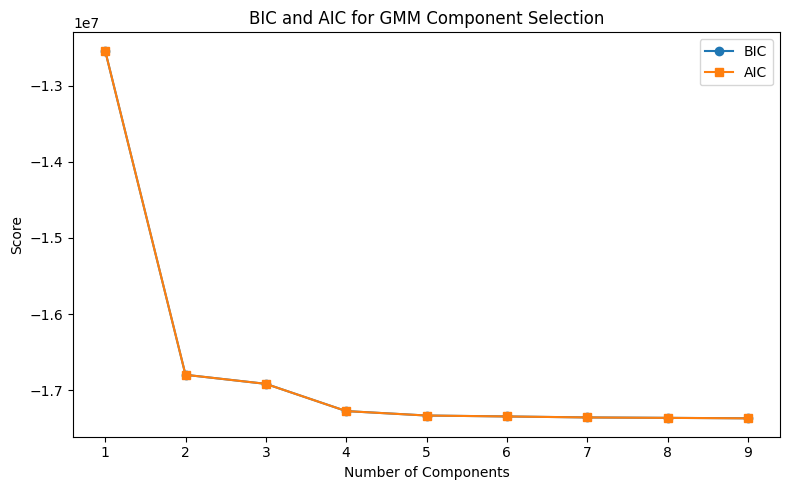

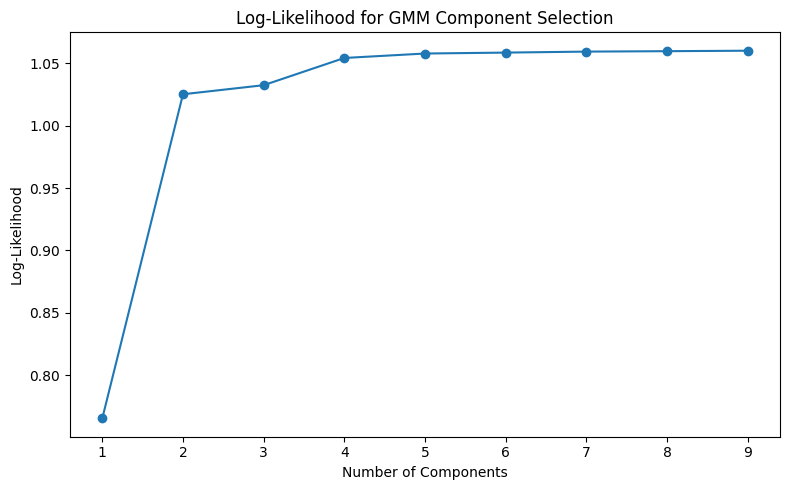

In [ ]:
# fit GMM to the data

# Extract nonzero intensities (ignore background)
intensities = image_array[image_array > 0].flatten()

# normalise
intensities = (intensities - np.min(intensities)) / (np.max(intensities) - np.min(intensities))

# Try different numbers of components
n_components_range = range(1, 10)
bics, aics, LL = [], [], []

for n in tqdm(n_components_range):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(intensities.reshape(-1, 1))
    
    bics.append(gmm.bic(intensities.reshape(-1, 1)))
    aics.append(gmm.aic(intensities.reshape(-1, 1)))
    LL.append(gmm.score(intensities.reshape(-1, 1)))

# Plot BIC and AIC scores
plt.figure(figsize=(8, 5))
plt.plot(n_components_range, bics, label="BIC", marker="o")
plt.plot(n_components_range, aics, label="AIC", marker="s")
plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.legend()
plt.title("BIC and AIC for GMM Component Selection")
plt.tight_layout()
plt.savefig('GMM_BIC_AIC.pdf', format='pdf')
plt.show()

# Plot log-likelihood
plt.figure(figsize=(8, 5))
plt.plot(n_components_range, LL, label="Log-Likelihood", marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood for GMM Component Selection")
plt.tight_layout()
plt.savefig('GMM_LL.pdf', format='pdf')
plt.show()


Identified Intensity Peaks: [0.08448136 0.16033765 0.31283162 0.49290103]


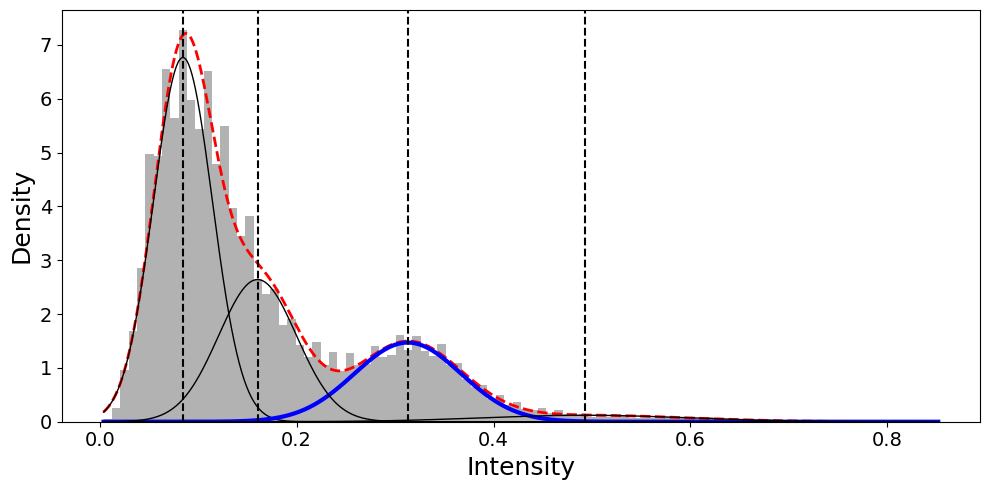

In [17]:
# read in file
image = sitk.ReadImage(files[0])
image_array = sitk.GetArrayFromImage(image)

# Extract nonzero intensities (ignore background)
intensities = image_array[image_array > 0].flatten()

# normalise the data
intensities = (intensities - np.min(intensities)) / (np.max(intensities) - np.min(intensities))

np.random.seed(42)
intensities = np.random.choice(intensities, 100000)

# Fit GMM with 4 components
n_components = 4  # Adjust based on expected tissue classes
gmm = GaussianMixture(n_components=n_components)
gmm.fit(intensities.reshape(-1, 1))

# Get Gaussian means (intensity peaks)
intensity_peaks = np.sort(gmm.means_.flatten())
print("Identified Intensity Peaks:", intensity_peaks)

# Extract parameters
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_).flatten()  # Standard deviation from variance
weights = gmm.weights_

# Plot Histogram with GMM Components
plt.figure(figsize=(10, 5))
plt.hist(intensities, bins=100, density=True, alpha=0.6, color="gray", label="Intensity Histogram")

# Plot Histogram as a KDE
#plot_histogram(plt.gca(), intensities, alpha=1, color="black", lw=2)

# Generate smooth curve for GMM
x = np.linspace(intensities.min(), intensities.max(), 1000)
gmm_pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
plt.plot(x, gmm_pdf, label="GMM Fit", color="red", linestyle="dashed", linewidth=2)

# Compute individual Gaussian components
individual_pdfs = [
    weights[i] * (1 / (stds[i] * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - means[i]) / stds[i])**2)
    for i in range(n_components)
]

# Plot individual Gaussian components
for i in range(n_components):
    lw = 3 if i == 1 else 1
    col = "blue" if i == 1 else "black"
    plt.plot(x, individual_pdfs[i], linewidth=lw, label=f"Component {i+1}", color=col)

# Mark identified peaks
for peak in intensity_peaks:
    plt.axvline(peak, color="black", linestyle="dashed", label=f"Peak: {peak:.4f}", linewidth=1.5)

#plt.legend()
#plt.title(f"GMM-Based Intensity Peak Detection in Knee MRI (Image {j+1})")
plt.xlabel("Intensity", fontsize=18)
plt.ylabel("Density", fontsize=18)

# ticks size
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.tight_layout()
plt.savefig('GMM_fit_example.pdf', format='pdf')
plt.show()

Ordered Intensity Peaks: [0.07913113 0.15532736 0.28605387 0.38129758]
Ordered Standard Deviations: [0.02709644 0.03910809 0.05654411 0.10523333]
Ordered Weights: [0.488075   0.26606897 0.1787457  0.06711033]


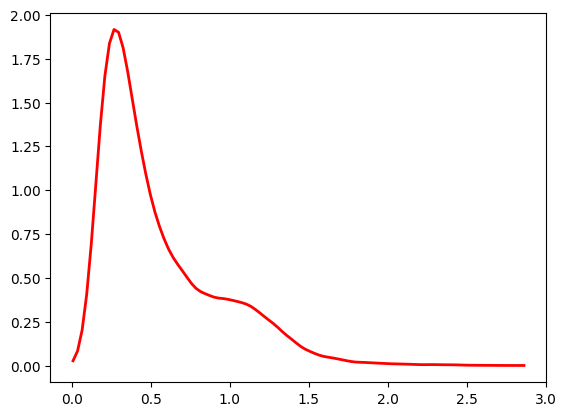

In [17]:
# Reorder gmm components by mean value
order = np.argsort(means)
means = means[order]
stds = stds[order]
weights = weights[order]

print("Ordered Intensity Peaks:", means)
print("Ordered Standard Deviations:", stds)
print("Ordered Weights:", weights)

# use 3rd peak to normalise the image
normalisation_peak = means[2]

# normalise the image
normalised_image = intensities / normalisation_peak

# plot the normalised image
fig, ax = plt.subplots()
plot_histogram(ax, normalised_image.ravel(), alpha=1, color='red', lw=2)

In [19]:
# write this as a function
def GMM_norm(intensities, n_components=4, peak_index=2):
    # extract nonzero intensities
    intensities = intensities[intensities > 0].flatten()

    # normalise the data
    intensities = (intensities - np.min(intensities)) / (np.max(intensities) - np.min(intensities))

    # Fit GMM with 3 components (assuming 3 main tissue types: bone, cartilage, muscle/fluid)
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(intensities.reshape(-1, 1))

    # Get Gaussian means (intensity peaks)
    intensity_peaks = np.sort(gmm.means_.flatten())

    # use 3rd peak to normalise the image
    normalisation_peak = intensity_peaks[peak_index]

    # normalise the image
    normalised = intensities / normalisation_peak

    return normalised

### Plot all the histograms for the train data before and after the transformation

100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:51<00:00,  1.33it/s]


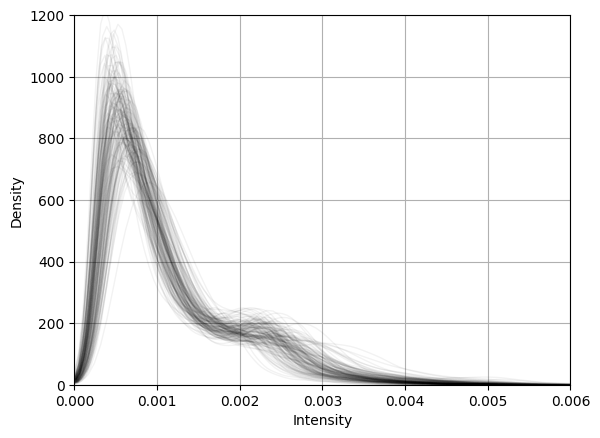

In [63]:
fig, ax = plt.subplots(dpi=100)
for path in tqdm(files):
    tensor = tio.ScalarImage(path).data
    values = tensor.numpy().ravel()

    # get sample of values
    sample = np.random.choice(values, 100000)
    plot_histogram(ax, sample)

ax.set_xlabel('Intensity')
ax.set_ylabel('Density')
ax.set_xlim(0, 0.006)
ax.set_ylim(0, 1200)
ax.grid()
plt.savefig('iwoai_histograms.pdf', format='pdf', bbox_inches='tight')

100%|█████████████████████████████████████████| 148/148 [04:22<00:00,  1.78s/it]


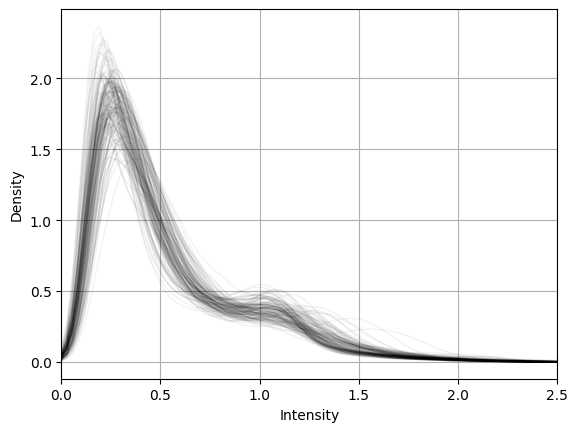

In [20]:
fig, ax = plt.subplots(dpi=100)

for path in tqdm(files):
    image = sitk.ReadImage(path)
    image_array = sitk.GetArrayFromImage(image)
    values = image_array[image_array > 0].flatten()

    # get sample of values
    sample = np.random.choice(values, 100000)

    normalised = GMM_norm(sample)
    plot_histogram(ax, normalised)

ax.set_xlabel('Intensity')
ax.set_ylabel('Density')
ax.set_xlim(0, 2.5)
ax.grid()
plt.savefig('iwoai_gmm_histograms.pdf', format='pdf', bbox_inches='tight')

### Now let's plot SKM-TEA

In [41]:
skmtea_path = '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/images_all_skmtea/'
skmtea_files = glob.glob(skmtea_path + '*')

In [42]:
skmtea_files.sort()
print('Number of files:', len(skmtea_files))
skmtea_files[:5]

Number of files: 155


['../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/images_all_skmtea/SKMTEA_001_0000.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/images_all_skmtea/SKMTEA_002_0000.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/images_all_skmtea/SKMTEA_003_0000.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/images_all_skmtea/SKMTEA_004_0000.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/images_all_skmtea/SKMTEA_005_0000.nii.gz']

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [03:28<00:00,  1.35s/it]


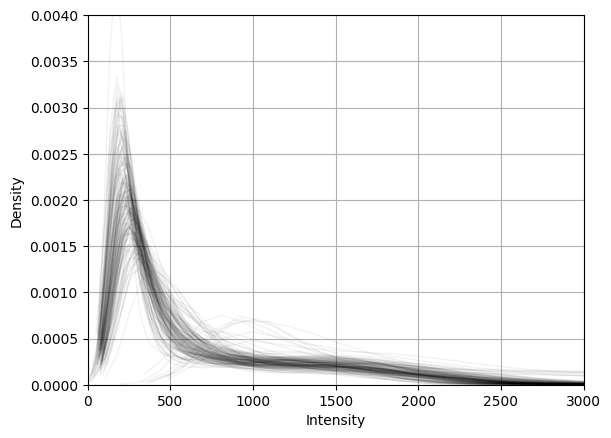

In [67]:
# plot skmtea histograms
fig, ax = plt.subplots()
for path in tqdm(skmtea_files):
    image = sitk.ReadImage(path)
    image = sitk.GetArrayFromImage(image)
    values = image.ravel()

    # get sample of values
    sample = np.random.choice(values, 100000)
    plot_histogram(ax, sample)

ax.set_xlabel('Intensity')
ax.set_ylabel('Density')
ax.set_xlim(0,3000)
ax.set_ylim(0,0.004)
ax.grid()
plt.savefig('skmtea_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

100%|█████████████████████████████████████████| 155/155 [05:55<00:00,  2.29s/it]


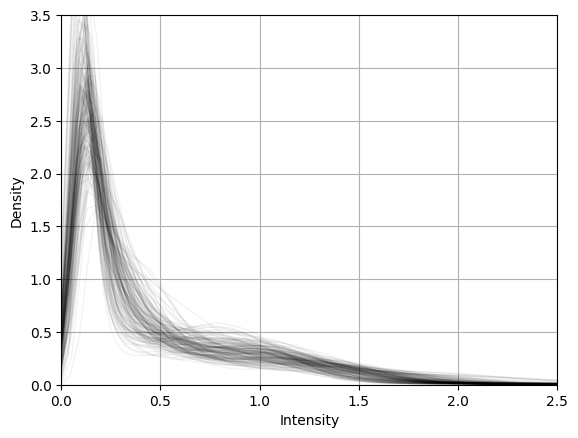

In [46]:
# plot skmtea histograms
fig, ax = plt.subplots()
for path in tqdm(skmtea_files):
    image = sitk.ReadImage(path)
    image = sitk.GetArrayFromImage(image)
    values = image.ravel()

    # get sample of values
    sample = np.random.choice(values, 100000)
    gmm_norm = GMM_norm(sample)
    plot_histogram(ax, gmm_norm)

ax.set_xlabel('Intensity')
ax.set_ylabel('Density')
ax.set_xlim(0, 2.5)
ax.set_ylim(0, 3.5)

ax.grid()
plt.savefig('skmtea_gmm_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()